In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 1. Structure of Data Sets

In [3]:
print(train.shape)
train.tail()

(647054, 7)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [5]:
print(test.shape)
test.tail()

(653646, 6)


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,Sunday,6.657211e+10,1,BATH AND SHOWER,1505.0
653642,191348,Sunday,8.818139e+10,1,BATH AND SHOWER,1099.0
653643,191348,Sunday,4.282557e+09,1,MENS WEAR,8220.0
653644,191348,Sunday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0
653645,191348,Sunday,7.871536e+09,1,MENS WEAR,4923.0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653646 entries, 0 to 653645
Data columns (total 6 columns):
VisitNumber              653646 non-null int64
Weekday                  653646 non-null object
Upc                      649660 non-null float64
ScanCount                653646 non-null int64
DepartmentDescription    652318 non-null object
FinelineNumber           649660 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 29.9+ MB


# 2. Columns

|        Columns        | Data Type |                                                     Description                                                     | Unique value |
|:---------------------:|:---------:|:-------------------------------------------------------------------------------------------------------------------:|:------------:|
|        TripType       |   int64   | 우리가 예측해야할것. 손님들의 쇼핑 타입을 나타냄. 각각의 숫자가 어떤 trip type인지에 대한 설명은 없음. 999번은 기타 |      38      |
|      VisitNumber      |   int64   | 한 사람의 손님을 나타내는 id(이에 해당하는 trip type도 하나)                                                        |     95674    |
|        Weekday        |   object  | 요일(월 ~ 일요일)                                                                                                   |       7      |
|          Upc          |  float64  | 구매한 물건의 UPC(Universal Product Code)                                                                           |     97715    |
|       ScanCount       |   int64   | 해당물건을 몇개 구입했는지 나타냄. 음수는 환불했음을 의미함. -12 ~71 까지 있음. 평균은 1.1                          |      39      |
| DepartmentDescription |   object  | 해당 물건의 상위레벨 분류. 마트의 코너 개념                                                                         |      69      |
|     FinelineNumber    |  float64  | Walmart에서 분류한 해당 물건의 좀 더 상세한 분류                                                                    |     5196     |

|        Columns        | Data Type |                          Description                              | Unique value |
|:---------------------:|:---------:|:-----------------------------------------------------------------:|:------------:|
|        TripType       |   int64   | - 우리가 예측해야할것                                             |      38      |
|                       |           | - 손님들의 쇼핑 타입을 나타냄                                     |              |
|                       |           | - 각각의 숫자가 어떤 trip type인지에 대한 설명은 없음             |              |
|                       |           | - 999번은 기타                                                    |              |
|      VisitNumber      |   int64   | - 한 사람의 손님을 나타내는 id                                    |     95674    |
|                       |           | - 이에 해당하는 trip type도 하나                                  |              |
|        Weekday        |   object  | - 요일(월 ~ 일요일)                                               |       7      |
|          Upc          |  float64  | - 구매한 물건의 UPC(Universal Product Code)                       |     97715    |
|       ScanCount       |   int64   | - 해당물건을 몇개 구입했는지 나타냄                               |      39      |
|                       |           | - 음수는 환불했음을 의미함                                        |              |
|                       |           | - -12 ~71 까지 있음                                               |              |
|                       |           | - 평균은 1.1                                                      |              |
| DepartmentDescription |   object  | - 해당 물건의 상위레벨 분류                                       |      69      |
|                       |           | - 마트의 코너 개념                                                |              |
|     FinelineNumber    |  float64  | - Walmart에서 분류한 해당 물건의 좀 더 상세한 분류                |     5196     |

# 3. Feature Engineering

### 3-1. Decoding UPCs

- About UPC

![Alt text](UPC_and_EAN.jpg)

- 주어진 UPC들의 길이
    - 1 ~ 12자리 까지 주어짐
    - 10자리와 11자리가 제일 많음
    - 1자리로된 UPC는 missing value로 처리함

In [4]:
c = [4129, 7, 29745, 372, 1, 412, 2166, 433341, 168418, 8463]
length_of_UPC = pd.DataFrame({"Length":[1,3,4,5,7,8,9,10,11,12]})
length_of_UPC["Count"] = c
length_of_UPC

,Length,Count
0,1,4129
1,3,7
2,4,29745
3,5,372
4,7,1
5,8,412
6,9,2166
7,10,433341
8,11,168418
9,12,8463


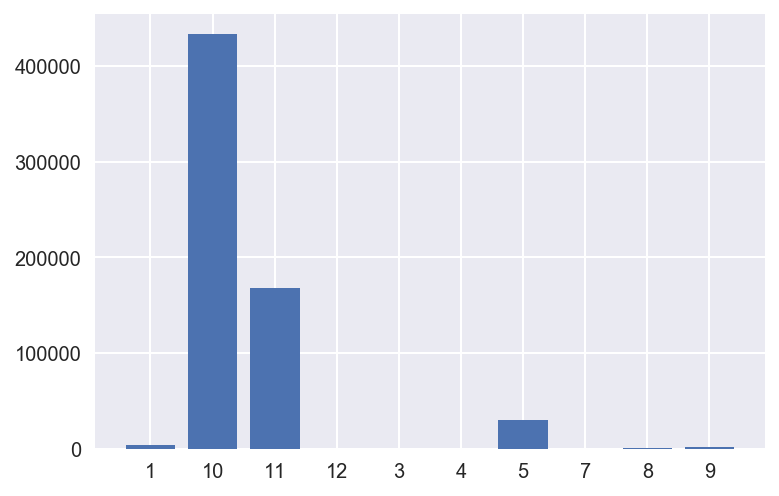

In [8]:
plt.bar(length_of_UPC["Length"].astype(str), length_of_UPC["Count"])
plt.show()

- Decoding UPCs

![Alt text](Decoding_UPCs.jpg)

-------------------

In [17]:
df = train.groupby("VisitNumber")["TripType"].apply(np.average)
df = pd.DataFrame(df)
df.reset_index(inplace=True)
df.tail()

,VisitNumber,TripType
95669,191343,25.0
95670,191344,22.0
95671,191345,39.0
95672,191346,39.0
95673,191347,8.0


In [23]:
df2 = df.groupby("TripType").size()
df2 = pd.DataFrame(df2)
df2.reset_index(inplace=True)
df2.rename(columns={0:"Count"}, inplace=True)
df2.tail()

,TripType,Count
33,41.0,583
34,42.0,1858
35,43.0,872
36,44.0,1187
37,999.0,8444


<function matplotlib.pyplot.show>

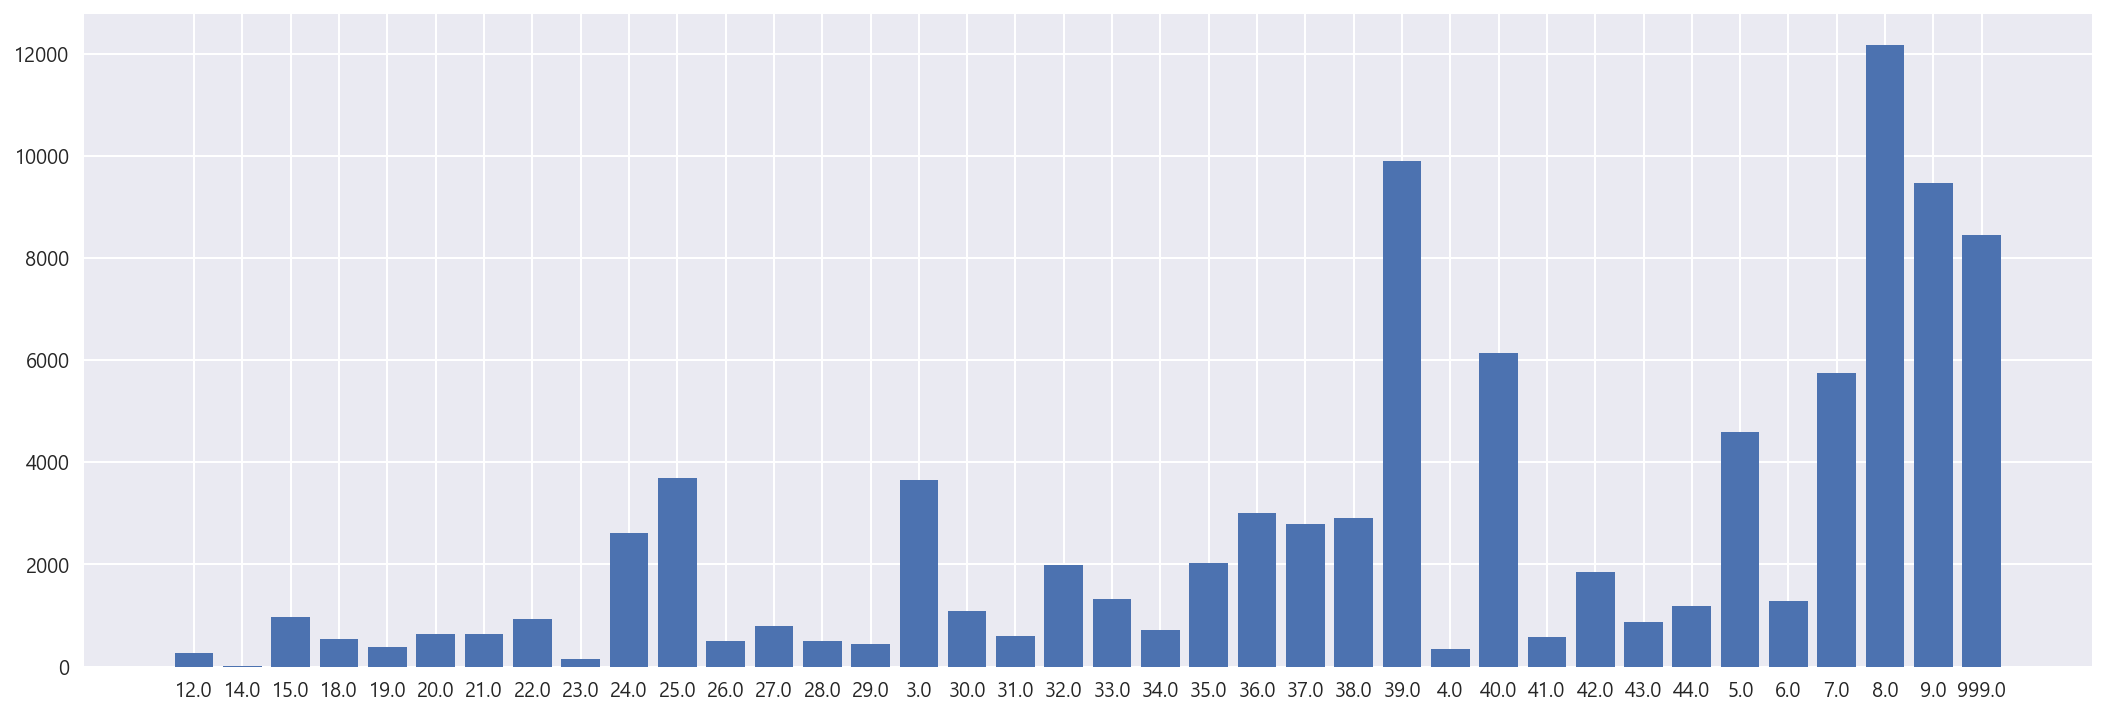

In [28]:
plt.figure(figsize=(18, 6))
plt.bar(df2["TripType"].astype(str), df2["Count"])
plt.show